<a href="https://colab.research.google.com/github/pansplawik/SegmentationBreastCancer/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *
import pathlib
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = []
masks = []

mask_dir = '/content/drive/MyDrive/aomP/benign_masks/benign_masks'

files = sorted([filename for filename in os.listdir(mask_dir) if filename.endswith('.png')])

# Przetwarzanie posortowanych plików
for filename in files:
    mask = cv2.imread(os.path.join(mask_dir, filename), 0)
    mask = mask / 255.0
    mask = cv2.resize(mask, (256, 256))
    mask = np.expand_dims(mask, axis=-1)
    print(mask.shape)
    masks.append(mask)

img_dir = '/content/drive/MyDrive/aomP/benign_data/benign_data'
files = sorted([filename for filename in os.listdir(img_dir) if filename.endswith('.png')])

# Przetwarzanie posortowanych plików
for filename in files:
    img = cv2.imread(os.path.join(img_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Konwertowanie na skalę szarości
    img = img / 255.0
    img = cv2.resize(img, (256,256))
    img = np.expand_dims(img, axis=-1)
    print(img.shape)
    images.append(img)

images = np.array(images)
masks = np.array(masks)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1)

In [ ]:
print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (393, 256, 256, 1)
y_train shape: (393, 256, 256, 1)
X_test shape: (44, 256, 256, 1)
y_test shape: (44, 256, 256, 1)


(256, 256, 1)


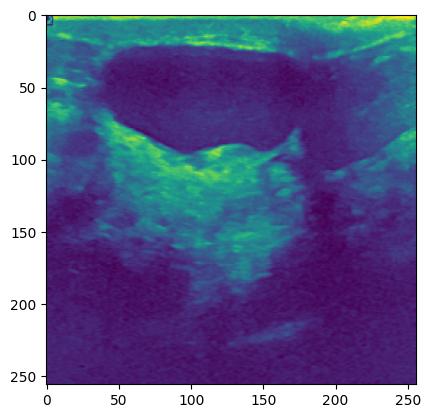

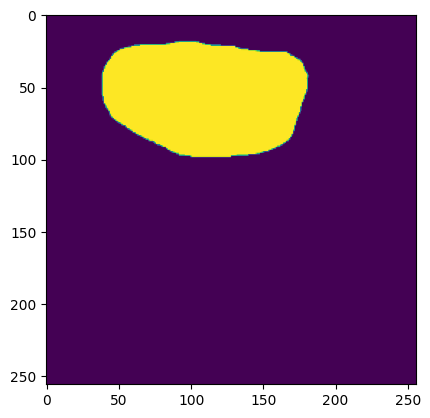

In [ ]:
print(X_train[0].shape)
plt.imshow(X_test[10])
plt.show()
plt.imshow(y_test[10])
plt.show()

In [ ]:
import os
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import imageio.v2 as imageio
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPool2D, Dropout
from keras import Input, Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
def create_upsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that upsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by an upsampling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = UpSampling2D(size=(2, 2))(x)
        return x
    return layer

def create_downsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that downsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by a max pooling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        return x
    return layer

dropout_rate = 0.15

# Example usage
inputs = Input(shape=(256, 256, 1))
# Encoder part of the DeepUNet
x = create_downsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
x = create_downsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(2048, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)

# Decoder part of the DeepUNet
x = create_upsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(32, 3, padding='same', kernel_initializer='he_normal')(x)
outputs = Conv2D(1, 1, padding = 'same', activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Define early stopping and reduce learning rate on plateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,
                              verbose=1, mode='auto')

In [ ]:
def dice_loss(y_true, y_pred):
    # Flatten the predictions and ground truth
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Compute the intersection and union
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union

    return dice_loss

# Compile the model with the Dice loss
model.compile(loss=dice_loss, optimizer='adam', metrics=['accuracy'])

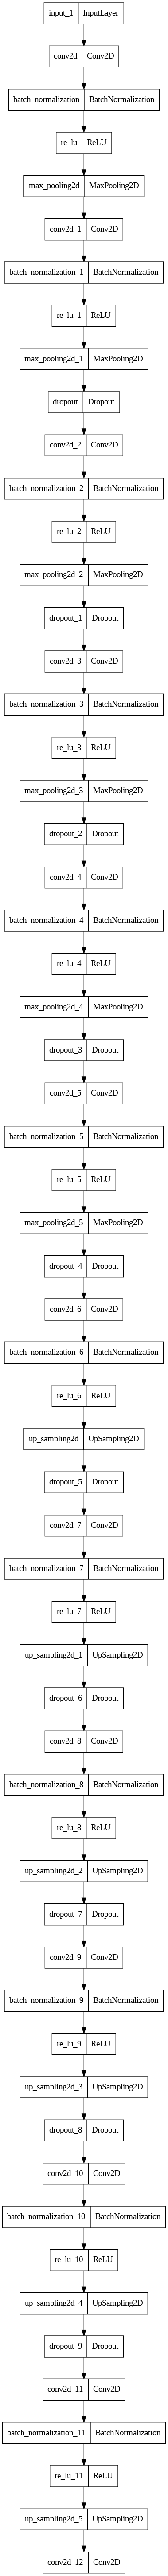

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# Define the number of epochs and the batch size
num_epochs = 50
batch_size = 16

# Set seed
# tf.random.set_seed(42)
tf.random.set_seed(1)

# Train the UNet model on the training data
history = model.fit(
                    X_train,
                     y_train,
                    batch_size=batch_size, epochs=num_epochs,
                    callbacks=[early_stop, reduce_lr],
                    validation_data=( X_test, y_test ))

Epoch 1/50
25/25 [==============================] - 263s 10s/step - loss: 0.7839 - accuracy: 0.6898 - val_loss: 0.8193 - val_accuracy: 0.0982 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 259s 10s/step - loss: 0.7339 - accuracy: 0.8277 - val_loss: 0.8165 - val_accuracy: 0.1083 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 262s 10s/step - loss: 0.6727 - accuracy: 0.8880 - val_loss: 0.7233 - val_accuracy: 0.7288 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 258s 10s/step - loss: 0.6268 - accuracy: 0.9118 - val_loss: 0.7373 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 258s 10s/step - loss: 0.5595 - accuracy: 0.9322 - val_loss: 0.7687 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 259s 10s/step - loss: 0.5265 - accuracy: 0.9324 - val_loss: 0.6258 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 263s 11s/step - lo

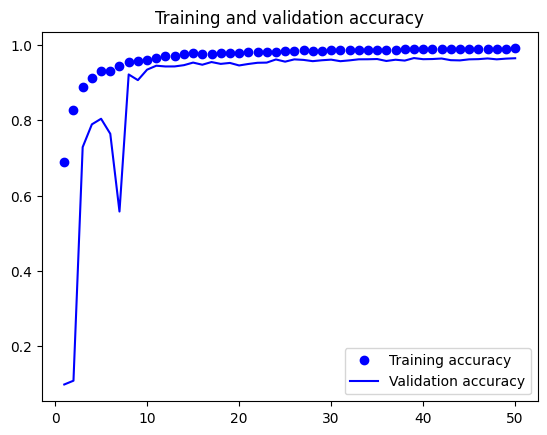

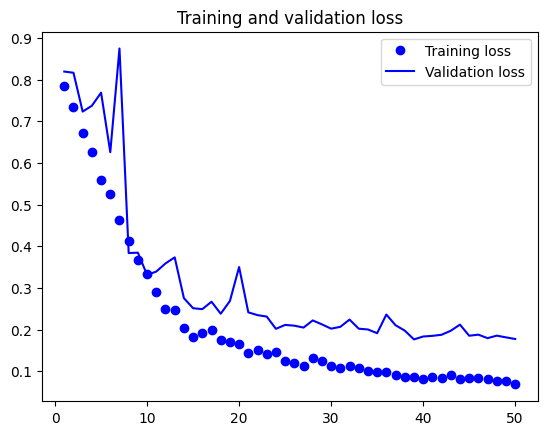

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


1/1 [==============================] - 0s 219ms/step


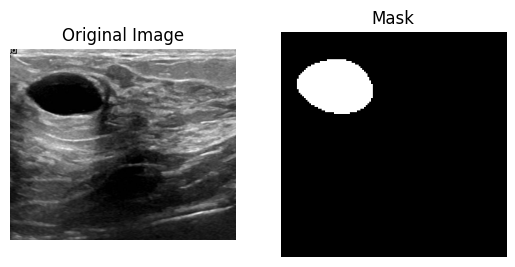

1/1 [==============================] - 0s 221ms/step


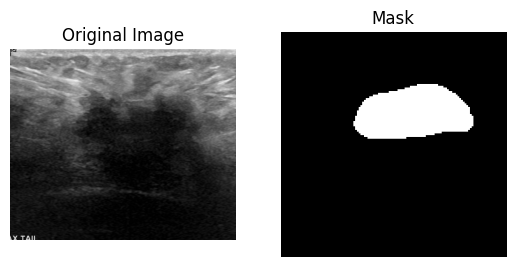

1/1 [==============================] - 0s 209ms/step


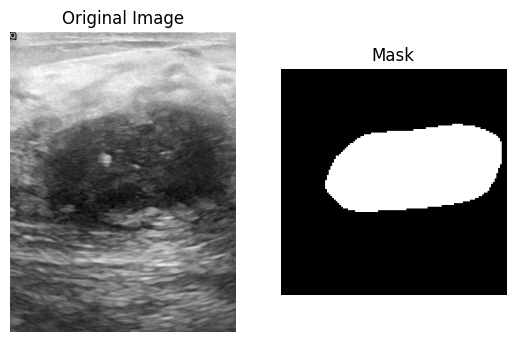

In [ ]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('benign_130.png')

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Resize the image
resized_image = cv2.resize(gray_image, (256, 256))

# Normalize pixel values to [0, 1]
resized_image = resized_image / 255.0

# Add batch dimension
resized_image = resized_image.reshape((1, 256, 256, 1))

# Predict
predictions = model.predict(resized_image)

# Create mask
threshold = 0.01
mask = np.zeros_like(predictions)
mask[predictions > threshold] = 1

# Display the original image and the mask side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(mask[0, :, :, 0], cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

# Load the image
image = cv2.imread('malignant.png')

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Resize the image
resized_image = cv2.resize(gray_image, (256, 256))

# Normalize pixel values to [0, 1]
resized_image = resized_image / 255.0

# Add batch dimension
resized_image = resized_image.reshape((1, 256, 256, 1))

# Predict
predictions = model.predict(resized_image)

# Create mask
threshold = 0.01
mask = np.zeros_like(predictions)
mask[predictions > threshold] = 1

# Display the original image and the mask side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(mask[0, :, :, 0], cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

# Load the image
image = cv2.imread('malignant_1.png')

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Resize the image
resized_image = cv2.resize(gray_image, (256, 256))

# Normalize pixel values to [0, 1]
resized_image = resized_image / 255.0

# Add batch dimension
resized_image = resized_image.reshape((1, 256, 256, 1))

# Predict
predictions = model.predict(resized_image)

# Create mask
threshold = 0.01
mask = np.zeros_like(predictions)
mask[predictions > threshold] = 1

# Display the original image and the mask side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(mask[0, :, :, 0], cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()
